# Setup
---

### Dependencies

In [1]:
# import modules
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# matplotlib dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
# sqlalchemy dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

### Reflect Tables into SQLAlchemy ORM

In [4]:
# create engine to database
engine  = create_engine("sqlite:///../Resources/hawaii.sqlite")

# declare a base
Base = automap_base()

# use base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [5]:
# view the classes mapped to the base
Base.classes.keys()

['measurement', 'station']

In [6]:
# assign each class to their own variable
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# create a session from python to database
session = Session(engine)

# Precipitation Analysis
---

### Find recent 12 month data

In [8]:
# find the most recent data in the dataset
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d').date()

# get the date from 12 months prior
year_ago_date = recent_date - dt.timedelta(days=365)

# display dates
print(f"Recent date: {recent_date}")
print(f"Year prior date: {year_ago_date}")

Recent date: 2017-08-23
Year prior date: 2016-08-23


In [ ]:
# perform query to get the previous 12 months of precipitation data (date and precipitation scores)
prcp_data_year_ago = (session.query(Measurement.date, Measurement.prcp)
                      .filter(Measurement.date >= year_ago_date)
                      .all())

# save the query results as a pandas dataframe sorted by date
prcp_data_df = pd.DataFrame(prcp_data_year_ago, columns=['Date', 'Inches']).sort_values(by='Date').reset_index(drop=True)

# display the df
prcp_data_df

,Date,Inches
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15
...,...,...
2225,2017-08-22,0.00
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


### See precipitation levels in past 12 months

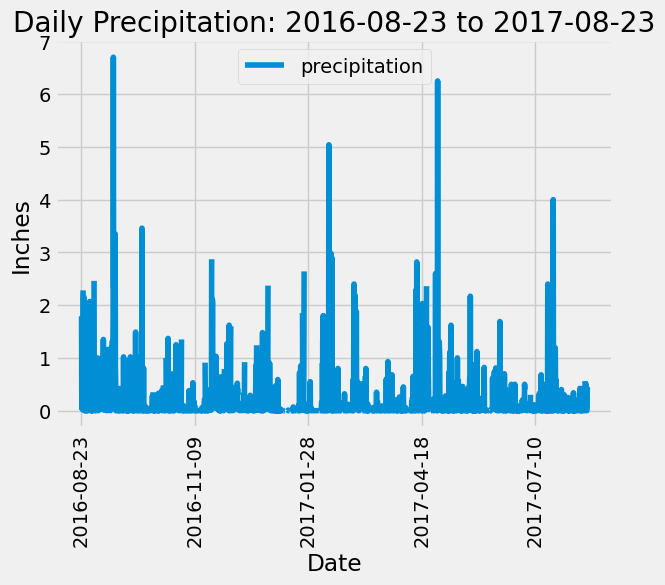

In [82]:
# plot daily precipitation data
prcp_data_df.plot(x='Date', y='Inches', rot=90,
                  ylabel='Inches', label='precipitation',
                  title=f'Daily Precipitation: {year_ago_date} to {recent_date}')

# show plot
plt.show()

### See summary stats for precipitation levels in past 12 months

In [ ]:
# calculate the summary stats for the precipitation data
prcp_data_df.describe()

,Inches
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis
---

### Find total number of stations

In [ ]:
# query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

### Find the most active stations (most active on top to least active)

In [ ]:
# query to find the most active stations (most rows)
active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                   .group_by(Measurement.station)
                   .order_by(func.count(Measurement.station).desc())
                   .all())

# display results
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### See the lowest, highest, and average temperuature at the most active station

In [ ]:
# get the most active station
most_active_station = active_stations[0][0]

# using the most active station id, calculate the lowest, highest, and average temperature
sel = [func.min(Measurement.tobs),  #lowest temp
       func.max(Measurement.tobs),  #highest temp
       func.avg(Measurement.tobs)]  #average temp

session.query(*sel).filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

### Find recent 12 month temperature data for the most active station

In [74]:
# query the last 12 months of temperature observation data for this station
temp_data_year_ago = (session.query(Measurement.tobs)
                      .filter(Measurement.station == most_active_station)
                      .filter(Measurement.date >= year_ago_date)
                      .all())

# convert data to dataframe
temp_df = pd.DataFrame(temp_data_year_ago)

### See the most active station's temperature frequency levels (based on recent 12 month data)

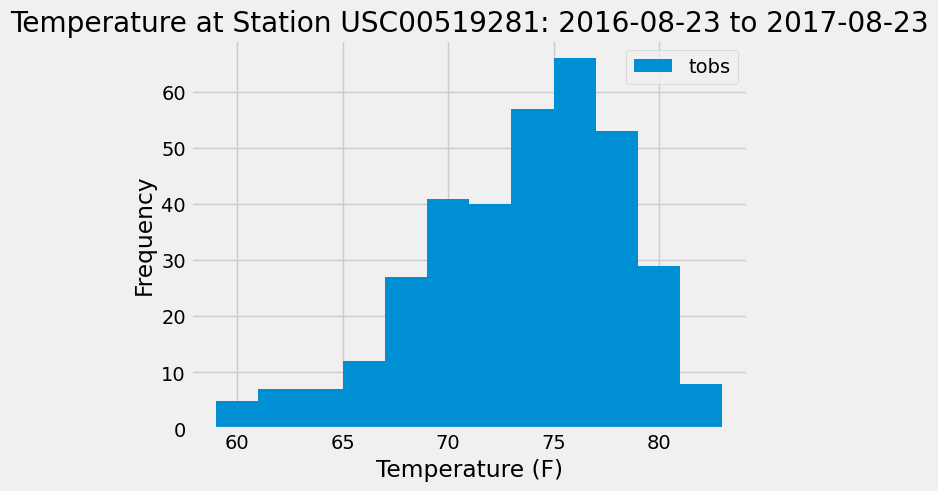

In [84]:
# convert to histogram
temp_df.plot.hist(bins=12, xlabel='Temperature (F)', ylabel='Frequency',
                  title=f'Temperature at Station {most_active_station}: {year_ago_date} to {recent_date}')

# show plot
plt.show()

In [76]:
# close session
session.close()